# Detecting patterns of speciation in the fos- sil record

In this assignment, we use data from the NOW (New and Old Worlds) database of fossil mammals to study patterns of speciation over time and space. In particular, we are interested to know when and where speciation rates have been significantly high. The task is to find which time periods and which places over the history of mammals have given rise to exceptionally high numbers of new species. The phenomenon is known in the evolutionary literature as the “species factory”. Palaeontologists are interested why and in which ways those times and places are special. The role of computational science is to identify and characterize such times and places.
We practice using pandas DataFrames, performing logistic regression and making statistical significance tests in data analysis.

First we import the necessary libraries.

In [219]:
import pandas as pd 
import matplotlib.pyplot as plt
import geopandas
import numpy as np

### Exercise 1 - 2
Download data from the NOW database. Create a pandas DataFrame that contains all of the data
and save it as a csv file. 

In [220]:
file_path = r'NOW.txt'
data = pd.read_csv(file_path)
data.to_csv('fossils.csv', index=False)

print(f"The DataFrame contains {data.shape[0]} rows.")


The DataFrame contains 82138 rows.


The dataframe consists of 82138 rows currently.

### Exercise 3
a) Remove all rows where LAT = LONG = 0; these occur￾rences have incorrect coordinates. Drop rows where SPECIES is “sp.” or
“indet.”; these occurrences have not been properly identified.

In [221]:
fossils = pd.read_csv(r"C:\Users\dream\Desktop\Fossils\fossils.csv")
fossils = fossils[(fossils["LAT"] != 0) | (fossils["LONG"] != 0)]
fossils = fossils[~fossils["SPECIES"].isin(["sp.", "indet."])]

b) Next we will assign each occurrence to a specific Mammal Neogene
(MN) time unit. Table 1 shows the time boundaries of each time unit.
Assign each occurrence to a correct time unit by calculating the mean of
MIN AGE and MAX AGE. If the mean age of an occurrence is precisely
on the boundary between two time units, assign the occurrence to the
older time unit. If the mean age of an occurrence is outside of the MN
time interval, assign it to a “pre-MN” or “post-MN” category.

In [222]:
fossils["MEAN_AGE"] = (fossils["MAX_AGE"] + fossils["MIN_AGE"])/2
fossils["MN"] = ""
    
MN = [(9999, "pre-MN"), (23, "pre-MN"), (21.7, "MN1"), (19.5, "MN2"), (17.2, "MN3"), (16.4, "MN4"), (14.2, "MN5"), (12.85, "MN6"), (11.2, "MN7-8"),
(9.9, "MN9"), (8.9, "MN10"), (7.6, "MN11"), (7.1, "MN12"), (5.3, "MN13"), (5, "MN14"), (3.55, "MN15"), (2.5, "MN16"), (1.9, "MN17"), (0.85, "MQ18"),
(0.01, "MQ19"), (0, "post-MN")] # given

for i in range(0, len(MN)):
    fossils.loc[(fossils["MEAN_AGE"] >= MN[i][0]) & (fossils["MEAN_AGE"] < MN[i-1][0]), "MN"] = MN[i][1] # this works to categorize mean ages to MN

c) Sometimes expert knowledge may be used to override some of the
information recorded in the data. In our case, experts in palaeontology
tell us that occurrences in the localities “Samos Main Bone Beds” and
“Can Llobateres I” should be assigned to time units MN12 and MN9,
respectively. Check these and if necessary, edit the time units to their
correct values.

In [223]:
fossils.loc[fossils["NAME"] == "Samos Main Bone Beds", "MN"] = "MN12" # based on expert recommendations
fossils.loc[fossils["NAME"] == "Can Llobateres I", "MN"] = "MN9"

d) We need to be able to identify all occurrences of each species. Assign
a unique identification number for each unique combination of GENUS
and SPECIES. Create a new column in the DataFrame and label each
occurrence with a corresponding species identification number.


In [224]:
fossils['ID'] = fossils.groupby(['GENUS', 'SPECIES']).ngroup() # unique identification based on GENUS and SPECIES

e) Each locality should contain no more than one occurrence of any
species. Check whether this is the case and remove duplicate copies, if
necessary.

In [225]:
fossils.drop_duplicates(subset=['LIDNUM', 'SPECIES'], inplace=True) 

f) How many rows are we left with in the DataFrame (compare with
exercise 2)? How many unique species and localities are identified?


In [226]:
total_rows = fossils.shape[0]
unique_species_locality_combinations = fossils[['LIDNUM', 'SPECIES']].drop_duplicates().shape[0]
unique_localities = fossils['LIDNUM'].nunique()
unique_species = fossils['SPECIES'].nunique()

print("Statistics after Exercise 3e:")
print("Total Rows:", total_rows)
print("Unique Species and Locality Combinations:", unique_species_locality_combinations)
print("Unique Localities:", unique_localities)
print("Unique Species:", unique_species)

Statistics after Exercise 3e:
Total Rows: 58647
Unique Species and Locality Combinations: 58647
Unique Localities: 6991
Unique Species: 6557


Compared to Exercise 2, we have 58643 rows from 82138 rows after making the necessary changes. There are 6989 unique localities and 6557 unique species.

### Exercise 4 

Create a DataFrame that shows for each species how many
occurrences it has in each time unit. Then, create a different DataFrame
that shows for each species the time unit when it is first observed (i.e.
the oldest time unit). For each time unit, calculate the proportion of first
occurrences to all occurrences. Plot the proportion of first occurrences
over time. Also, plot the total number of occurrences over time.


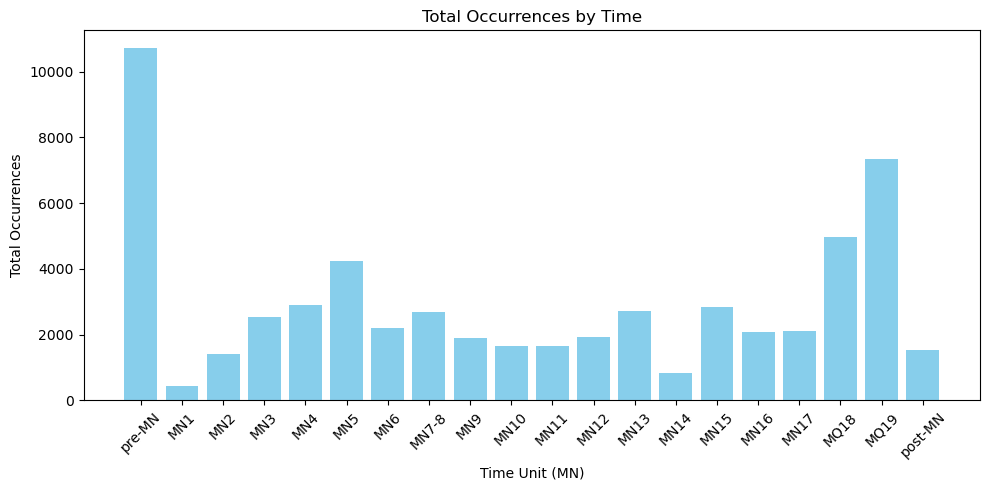

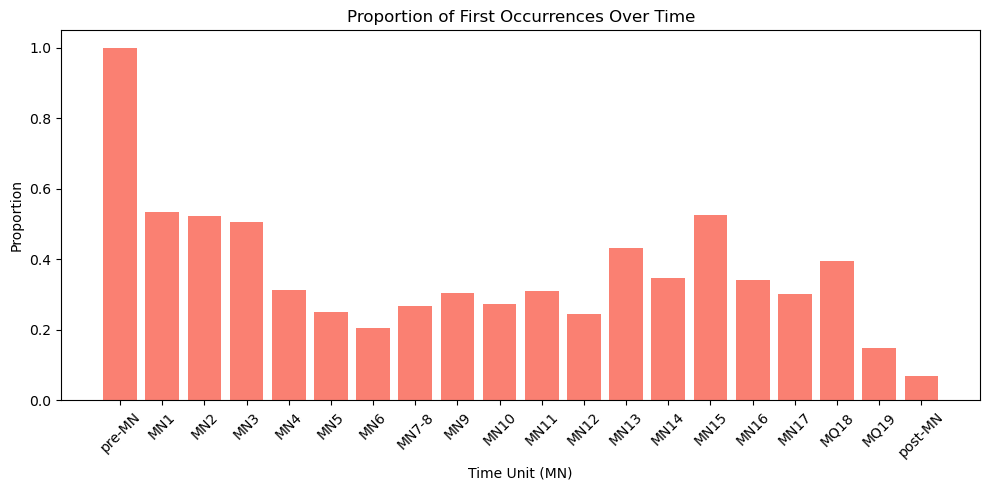

In [227]:
occurrences_by_time = fossils.groupby(['ID', 'MN']).size().unstack(fill_value=0) # a dataframe consisting of all occurrences of every species in MN periods
MN_order = ["pre-MN", "MN1", "MN2", "MN3", "MN4", "MN5", "MN6", "MN7-8", "MN9", "MN10", "MN11", "MN12", "MN13", "MN14",  "MN15", "MN16", "MN17", "MQ18", "MQ19", "post-MN"] 
occurrences_by_time = occurrences_by_time.reindex(columns=MN_order, fill_value=0) # necessary to categorise correctly

oldest_time_unit_for_species = occurrences_by_time.ne(0).idxmax(axis=1) # first non-zero value
oldest_time_unit_array = oldest_time_unit_for_species.to_numpy() # for masking purposes

mask = (occurrences_by_time.columns.to_numpy() == oldest_time_unit_array[:, None])
first_occurrences_by_time = occurrences_by_time.where(mask, 0)

total_occurrences_by_time_sum = occurrences_by_time.sum(axis=0) 
first_occurrences_by_time_sum = first_occurrences_by_time.sum(axis=0)
proportion_of_occurrences_by_time = first_occurrences_by_time_sum / total_occurrences_by_time_sum

# Plotting total occurrences over time
plt.figure(figsize=(10, 5))
plt.bar(MN_order, total_occurrences_by_time_sum, color='skyblue')
plt.title('Total Occurrences by Time')
plt.xlabel('Time Unit (MN)')
plt.ylabel('Total Occurrences')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting proportion of first occurrences over time
plt.figure(figsize=(10, 5))
plt.bar(MN_order, proportion_of_occurrences_by_time, color='salmon')
plt.title('Proportion of First Occurrences Over Time')
plt.xlabel('Time Unit (MN)')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Total Occurences by Time Figure
<img src="output1.png">

Most occurences are in pre-MN, with over 10000 total occurences. Very few are in MN1, and the pattern varies after that.


#### Proportion of First Occurrences Over Time
<img src="output2.png">

As expected, proportion of first occurrences is 1 in pre-MN since it is the first time period. Following this it gradually decreases before increasing again from MN7-8, and then varies.


### Exercise 5

a) Create a DataFrame that collects the following information for every locality: locality number (LIDNUM), longitude, latitude,
time unit, number of first occurrences in the locality, number of all occur￾rences in the locality and proportion of first occurrences in the locality. Note, you should use LIDNUM to identify unique localities and not the
NAME variable (why?).


In [228]:
total_occurrences_by_locality = fossils.groupby(['ID', 'LIDNUM']).size().unstack(fill_value=0).sum(axis=0) # counts all occurences of IDs in a locality

fossils['MN_order'] = fossils['MN'].apply(lambda x: MN_order.index(x)) # numerifies the MN order for later purposes
earliest_indices = fossils.groupby('ID')['MN_order'].idxmin() # group by ID and find the index of the earliest MN occurrence for each ID
existing_lidnums = fossils['LIDNUM'].unique() # avoid duplicates

first_occurrences_by_locality = fossils.loc[earliest_indices, ['ID', 'LIDNUM']] # filter

first_occurrences_by_locality = first_occurrences_by_locality.groupby('LIDNUM').size()
first_occurrences_by_locality = first_occurrences_by_locality.reindex(existing_lidnums, fill_value=0)

localities = fossils[["LIDNUM", "LAT", "LONG", "MN", "MN_order"]] # we need only these details
new_df = pd.concat([first_occurrences_by_locality.rename("First Occurrences"), total_occurrences_by_locality.rename("Total Occurrences")], axis=1)
new_df['Proportions'] = new_df['First Occurrences'] / new_df['Total Occurrences'] # proportion of first occurrences to total occurrences
localities = pd.merge(localities, new_df, on='LIDNUM', how='left')
localities.drop_duplicates(subset=['LIDNUM'], inplace=True) 
localities.sort_values(by='LIDNUM', inplace=True) # to ensure proper order

print(localities) # view the table

       LIDNUM        LAT        LONG       MN  MN_order  First Occurrences  \
7012    10001  19.433330  -99.133333      MN2         2                  1   
7013    10002  16.898056  -96.414167      MN3         3                  2   
7020    10003  17.050000  -96.716667      MN5         5                  0   
7021    10004  17.050000  -96.716667      MN5         5                  5   
7029    10005  17.050000  -96.716667      MN6         6                  0   
...       ...        ...         ...      ...       ...                ...   
57394   29561  34.983333  106.166667     MQ19        18                  0   
24848   29562   2.568056   36.177500     MQ18        17                  2   
15469   29563  30.140000  115.250000     MQ19        18                  0   
18039   29564  22.950000  112.050000  post-MN        19                  0   
4334    29571  41.973611 -111.601667  post-MN        19                 13   

       Total Occurrences  Proportions  
7012                   

We must use LIDNUM instead of NAME because there might be duplicate, similar names to localities but the LIDNUM has to be unique.

b) Visualize the distribution of localities in space and time. For each time
unit, plot the LAT and LONG coordinates of each locality (corresponding
to the time unit). For example, you can use the above codes to create a
geographic map and then use a standard matplotlib scatter plot to add
the localities. Choose the marker size for each locality such that it is
relative to the number of occurrences in the locality (bigger markers for
bigger localities).

C:\Users\dream\AppData\Local\Temp\ipykernel_18020\2232805166.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


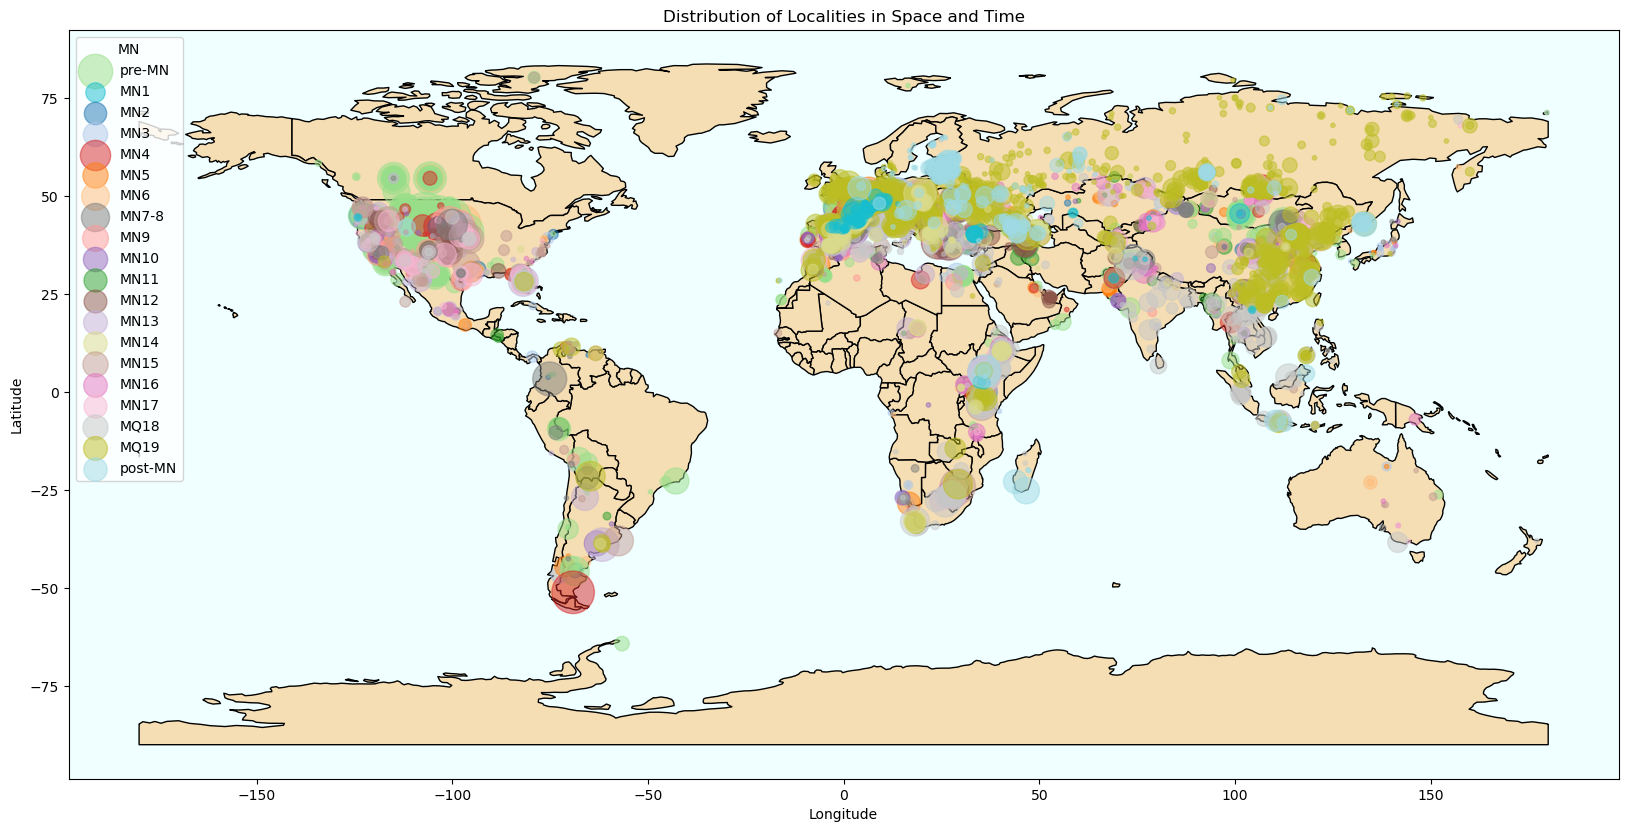

In [229]:
import matplotlib.colors as mcolors

# starter code
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(20, 10))
world.plot(ax=ax, color='wheat', edgecolor='black')
ax.set_facecolor('azure')

# scatter plot
unique_mns = localities['MN'].unique()
num_unique_mns = len(unique_mns)
cmap = plt.get_cmap('tab20', num_unique_mns)  # choose a colormap
norm = mcolors.Normalize(vmin=0, vmax=num_unique_mns - 1)  # normalize colormap indices

# time periods
for i, mn in enumerate(unique_mns):
    mn_localities = localities[localities['MN'] == mn]
    marker_sizes = mn_localities['Total Occurrences'] * 10  # adjust marker size based on total occurrences
    ax.scatter(mn_localities['LONG'], mn_localities['LAT'], s=marker_sizes, alpha=0.5, label=mn, color=cmap(norm(i)))

# legend
handles, labels = plt.gca().get_legend_handles_labels()
sorted_handles = [handles[labels.index(mn)] for mn in MN_order if mn in labels]
sorted_labels = [mn for mn in MN_order if mn in labels]
ax.legend(sorted_handles, sorted_labels, title='MN')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Distribution of Localities in Space and Time')
plt.show()

#### World Map with Distribution of Localities in Space and Time
<img src="output3.png">

c) Based on exercises 4 and 5, what kind of observations about sampling
can you make? Are there differences in sampling density over space and
time? Compare some basic sampling properties between Africa, Asia and
Europe, e.g. spatial coverage and average number of occurrences per
locality.

From a basic overview, it is obvious that there is major difference between sampling density in space, with Europe, North America and East China having the highest sampling density, with little sampling in South America, Africa and Oceania. Sampling in East China is mostly in MQ19. In Africa and Europe the time periods are more varied. 

In [230]:
# basic bboxes for continent range, not very accurate, courtesy of bboxfinder.com
continents = {
    'Europe': (-29.531250,36.597889,47.636719,71.130988),
    'Asia': (47.988281,-11.005904,193.710938,76.720223),   
    'Africa': (-21.796875,-35.460670,53.789063,35.746512), 
}

total_coverage = {}
avg_occurrences = {}

# the for loop filters the localities according to the continent bboxes
for region, bbox in continents.items():
    region_localities = localities[(localities['LAT'] >= bbox[1]) & (localities['LAT'] <= bbox[3]) &
                                (localities['LONG'] >= bbox[0]) & (localities['LONG'] <= bbox[2])] # includes localities that correspond with latitude and longitude
    total_coverage[region] = len(region_localities)
    avg_occurrences[region] = region_localities['Total Occurrences'].sum() / total_coverage[region]

print("Spatial coverage:")
for region, coverage in total_coverage.items():
    print(f"{region} : {coverage}")

print("\nAverage number of occurrences per locality:")
for region, avg in avg_occurrences.items():
    print(f"{region} : {avg:.2f}")

Spatial coverage:
Europe : 3740
Asia : 1364
Africa : 696

Average number of occurrences per locality:
Europe : 7.91
Asia : 6.92
Africa : 9.39


Because of the bbox limitations, Africa includes parts of Western Asia as well. Europe includes Western Russia and Caucasus, as well as Turkey. Asia lacks most of its western part, but includes Indonesia and other islands.

Europe has the most localities with fossils discovered by far, followed by Asia and Africa. Localities in Africa tend to have a higher density of fossils discovered, followed by Europe and Asia. This does not necessarily indicate that fewer fossils exist in these regions, only that fewer have been discovered. Highest concentrations of fossils are spread throughout Europe. Africa has spots with high concentrations of fossils, while Asia has fewer fossils spread out over bigger distances.

### Exercise 6

For each locality, look at a ten by ten degrees area (in
latitude and longitude) centered around the locality. Record the total
number of occurrences and total number of first occurrences found within
that square in the time unit corresponding to the focal locality. Also,
record the total number of occurrences within that square in the preceding
time unit (relative to the focal locality). Record these numbers into the
DataFrame that was created in exercise 5 (add new columns).

In [231]:
# latitude += 5, longitude +- 5

for index, locality in localities.iterrows(): # this might take a while
    # latitude and longitude ranges
    min_lat = locality['LAT'] - 5
    max_lat = locality['LAT'] + 5
    min_long = locality['LONG'] - 5
    max_long = locality['LONG'] + 5

    # mask for the ranges
    mask = localities[(localities['LAT'] >= min_lat) & 
                      (localities['LAT'] <= max_lat) & 
                      (localities['LONG'] >= min_long) & 
                      (localities['LONG'] <= max_long)]

    same_time_period = mask[mask['MN'] == locality['MN']] # ensure same time period
    total_occurrences_focal = same_time_period['Total Occurrences'].sum()
    total_first_occurrences_focal = same_time_period['First Occurrences'].sum()

    preceding_time_unit = locality['MN_order'] - 1 # MN_order is numerical for MN
    preceding_time_period = mask[mask['MN_order'] == preceding_time_unit]
    total_occurrences_preceding = preceding_time_period['Total Occurrences'].sum()
    
    # update the values accordingly
    localities.loc[index, "Total Occurrences 10x10"] = total_occurrences_focal
    localities.loc[index, "First Occurrences 10x10"] = total_first_occurrences_focal
    localities.loc[index, "Total Occurrences Preceding MN"] = total_occurrences_preceding

print(localities)
#localities.to_csv('locals.csv', index=False)



       LIDNUM        LAT        LONG       MN  MN_order  First Occurrences  \
7012    10001  19.433330  -99.133333      MN2         2                  1   
7013    10002  16.898056  -96.414167      MN3         3                  2   
7020    10003  17.050000  -96.716667      MN5         5                  0   
7021    10004  17.050000  -96.716667      MN5         5                  5   
7029    10005  17.050000  -96.716667      MN6         6                  0   
...       ...        ...         ...      ...       ...                ...   
57394   29561  34.983333  106.166667     MQ19        18                  0   
24848   29562   2.568056   36.177500     MQ18        17                  2   
15469   29563  30.140000  115.250000     MQ19        18                  0   
18039   29564  22.950000  112.050000  post-MN        19                  0   
4334    29571  41.973611 -111.601667  post-MN        19                 13   

       Total Occurrences  Proportions  Total Occurrences 10x10 

### Exercise 7

a) Create the regression data set. Only use localities within
the co-ordinates -25<LONG<40 and LAT>35 and time unit within MN2-
MQ19 (why not include MN1?). Create an m × 2 array, where m is the
total number of occurrences in all the localities. Each row in the array
represents one occurrence. For each occurrence, fill in to the first column
of the array the number of occurrences in the focal area in the previous
time unit (calculated in exercise 6). For the second column, fill in 1 for a
first occurrence and 0 for other occurrences.


In [232]:
import statsmodels.api as sm

# filter localities to ensure only European locations and MN2+ time period
filtered_localities = localities[(localities['LONG'] > -25) & (localities['LONG'] < 40) & (localities['LAT'] > 35) & (localities['MN_order'] >= 2)] # note that MN_order >= 2 is MN2 or later.
#total_occurrences = filtered_localities['Total Occurrences'].sum()
regression_data = []

for index, locality in filtered_localities.iterrows(): # iterate across the localities
    occurrences_preceding = locality["Total Occurrences Preceding MN"]
    occurrence = 0 # count of occurrences
    first_occurrence = 0 # count of first occurrences
    while first_occurrence < locality["First Occurrences"]: # to ensure number of first occurrences is reflected
        first_occurrence += 1
        occurrence += 1
        regression_data.append([occurrences_preceding, 1]) 
    while occurrence < locality["Total Occurrences"]:
        occurrence += 1
        regression_data.append([occurrences_preceding, 0])
regression_data = np.array(regression_data) # convert to np array from list of tuples

print(filtered_localities)
#filtered_localities.to_csv('filtered_localities.csv', index=False)


       LIDNUM        LAT       LONG     MN  MN_order  First Occurrences  \
50793   20001  48.686400  10.062200  MN7-8         7                  2   
46349   20002  43.900000  -0.500000    MN6         6                  2   
40909   20003  39.976800  28.307100    MN6         6                  4   
27913   20004  45.600533   5.232575  MN7-8         7                  2   
2901    20005  48.100000   2.150000    MN5         5                  2   
...       ...        ...        ...    ...       ...                ...   
45667   29538  48.523056  17.894444   MN12        11                  6   
43000   29539  48.684566  18.209187   MN12        11                  0   
47291   29540  48.305150  17.700899   MN12        11                  0   
33880   29544  36.292778  22.923056   MQ19        18                  0   
38525   29554  49.181389  16.551111    MN3         3                  1   

       Total Occurrences  Proportions  Total Occurrences 10x10  \
50793                 46     0.04

b) Perform logistic regression.

In [233]:
# logistic regression using statsmodels library
X = regression_data[:, 0]  
X = sm.add_constant(X)  
y = regression_data[:, 1]  
model = sm.Logit(y, X)
result = model.fit()

print(result.summary())

coefficients = result.params
confidence95 = result.conf_int(alpha=0.05)

Optimization terminated successfully.
         Current function value: 0.296410
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                25934
Model:                          Logit   Df Residuals:                    25932
Method:                           MLE   Df Model:                            1
Date:                Sun, 24 Mar 2024   Pseudo R-squ.:                 0.01734
Time:                        02:14:37   Log-Likelihood:                -7687.1
converged:                       True   LL-Null:                       -7822.7
Covariance Type:            nonrobust   LLR p-value:                 6.042e-61
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9206      0.032    -60.835      0.000      -1.982      -1.859
x1            -0.0012   8.22e

c) Plot regression curve and 95%-confidence intervals.

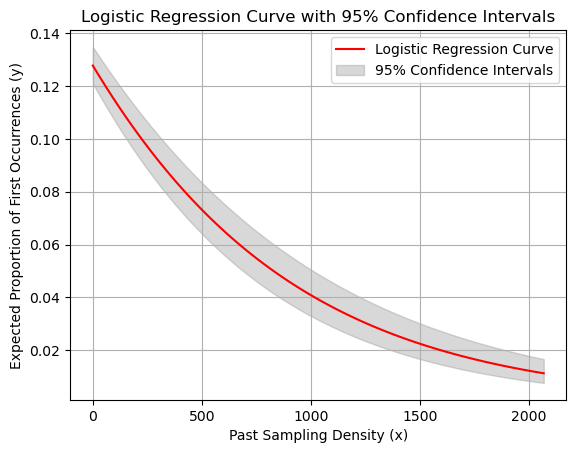

In [234]:
def logistic_regression_curve(x, c0, c1): # function for curve as given
    return 1 / (1 + np.exp(-(c0 + c1 * x)))

x_values = np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), 100)  # x values for plotting purposes
y_values = logistic_regression_curve(x_values, *coefficients)  # determine y values using the function

#plt.plot(X, y, 'bo', label='Data') # plot data if curious
plt.plot(x_values, y_values, 'r-', label='Logistic Regression Curve') 

confidence_lower = logistic_regression_curve(x_values, *confidence95[:, 0]) # lower bound of confidence interval
confidence_upper = logistic_regression_curve(x_values, *confidence95[:, 1]) # upper bound of confidence interval

plt.fill_between(x_values, confidence_lower, confidence_upper, color='gray', alpha=0.3, label='95% Confidence Intervals')

plt.xlabel('Past Sampling Density (x)')
plt.ylabel('Expected Proportion of First Occurrences (y)')
plt.title('Logistic Regression Curve with 95% Confidence Intervals')
plt.legend()
plt.grid(True)
plt.show()


#### Regression Curve and Confidence Intervals
<img src="output4.png">

### Exercise 8

For each European locality, calculate the expected proportion of first occurrences in the focal area surrounding the locality using
the logistic regression calculated in exercise 7.

In [235]:
expected_proportions = []

for index, locality in filtered_localities.iterrows():

    x = locality["Total Occurrences Preceding MN"]
    expected_proportion = logistic_regression_curve(x, *coefficients)
    expected_proportions.append(expected_proportion)

expected_proportions = np.array(expected_proportions)
filtered_localities["Expected Proportion of First Occurrences"] = expected_proportions

print(filtered_localities)
#filtered_localities.to_csv('filtered_localities_updated.csv', index=False)

       LIDNUM        LAT       LONG     MN  MN_order  First Occurrences  \
50793   20001  48.686400  10.062200  MN7-8         7                  2   
46349   20002  43.900000  -0.500000    MN6         6                  2   
40909   20003  39.976800  28.307100    MN6         6                  4   
27913   20004  45.600533   5.232575  MN7-8         7                  2   
2901    20005  48.100000   2.150000    MN5         5                  2   
...       ...        ...        ...    ...       ...                ...   
45667   29538  48.523056  17.894444   MN12        11                  6   
43000   29539  48.684566  18.209187   MN12        11                  0   
47291   29540  48.305150  17.700899   MN12        11                  0   
33880   29544  36.292778  22.923056   MQ19        18                  0   
38525   29554  49.181389  16.551111    MN3         3                  1   

       Total Occurrences  Proportions  Total Occurrences 10x10  \
50793                 46     0.04

C:\Users\dream\AppData\Local\Temp\ipykernel_18020\1879923448.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_localities["Expected Proportion of First Occurrences"] = expected_proportions


### Exercise 9

For each European locality, calculate the probability of observing as many or more first occurrences in the focal area than what is
actually found. Assume that occurrences are binomially distributed to
“first occurrences” and “not first occurrences”, so that the probability of
a given occurrence to be a first occurrence is equal to the expected proportion of first occurrences in the focal area. You may use, for example,
the scipy.stats.binom library (https://docs.scipy.org/doc/scipy-0.14.0/
reference/generated/scipy.stats.binom.html) for the calculations.


In [236]:
from scipy.stats import binom

probabilities = []

# Iterate over each European locality
for index, locality in filtered_localities.iterrows():
    probability = 1 - binom.cdf(locality["First Occurrences"], locality["Total Occurrences"], locality["Expected Proportion of First Occurrences"])
    probabilities.append(probability)

probabilities = np.array(probabilities)
filtered_localities["Probability"] = probabilities

print(filtered_localities)
#filtered_localities.to_csv('filtered_localities_updated.csv', index=False)

       LIDNUM        LAT       LONG     MN  MN_order  First Occurrences  \
50793   20001  48.686400  10.062200  MN7-8         7                  2   
46349   20002  43.900000  -0.500000    MN6         6                  2   
40909   20003  39.976800  28.307100    MN6         6                  4   
27913   20004  45.600533   5.232575  MN7-8         7                  2   
2901    20005  48.100000   2.150000    MN5         5                  2   
...       ...        ...        ...    ...       ...                ...   
45667   29538  48.523056  17.894444   MN12        11                  6   
43000   29539  48.684566  18.209187   MN12        11                  0   
47291   29540  48.305150  17.700899   MN12        11                  0   
33880   29544  36.292778  22.923056   MQ19        18                  0   
38525   29554  49.181389  16.551111    MN3         3                  1   

       Total Occurrences  Proportions  Total Occurrences 10x10  \
50793                 46     0.04

C:\Users\dream\AppData\Local\Temp\ipykernel_18020\1966694532.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_localities["Probability"] = probabilities


### Exercise 10

For each time unit, plot localities on a map covering the
coordinates defined in exercise 7a and indicate their significance level with
a sliding color scheme. Highlight localities that have p-value less than
0.05 (i.e. probability of observations is less than 0.05). Describe briefly
the overall patterns that you observe.

C:\Users\dream\AppData\Local\Temp\ipykernel_18020\1669705606.py:19: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


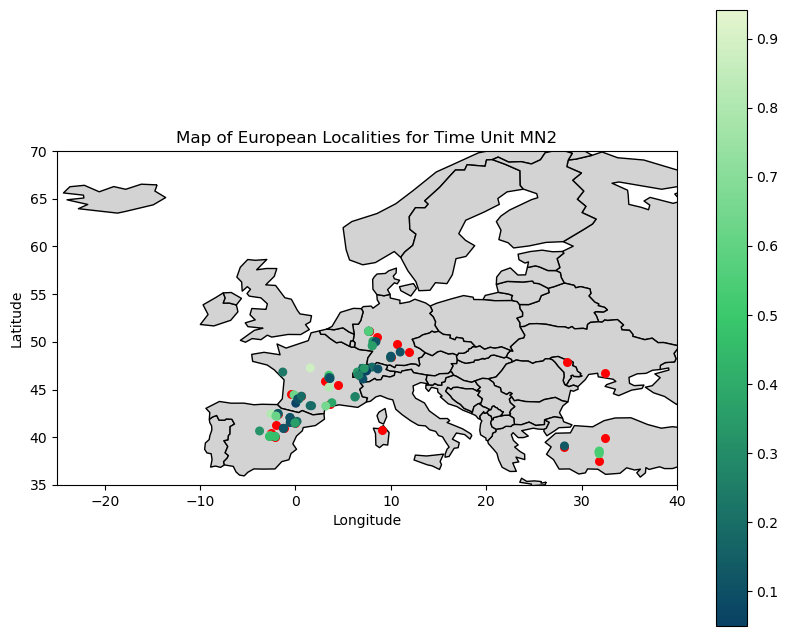

C:\Users\dream\AppData\Local\Temp\ipykernel_18020\1669705606.py:19: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


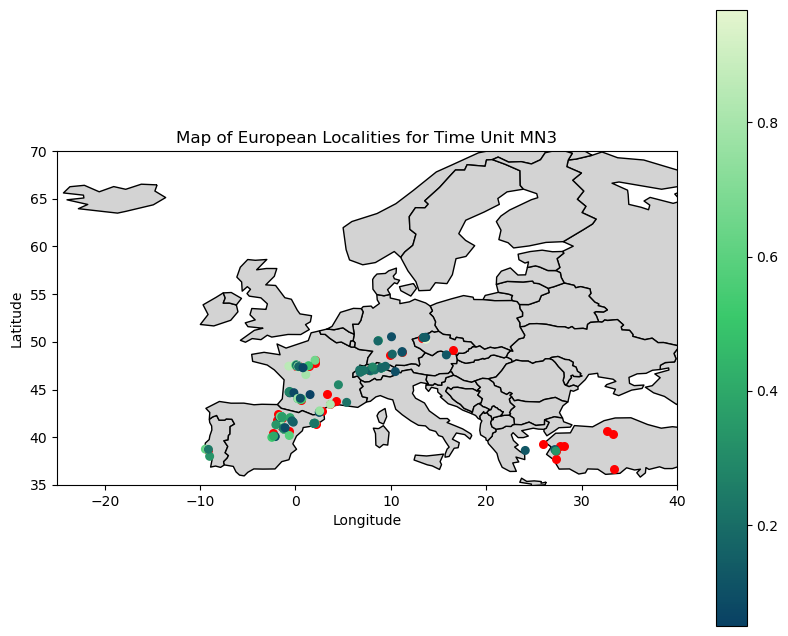

C:\Users\dream\AppData\Local\Temp\ipykernel_18020\1669705606.py:19: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


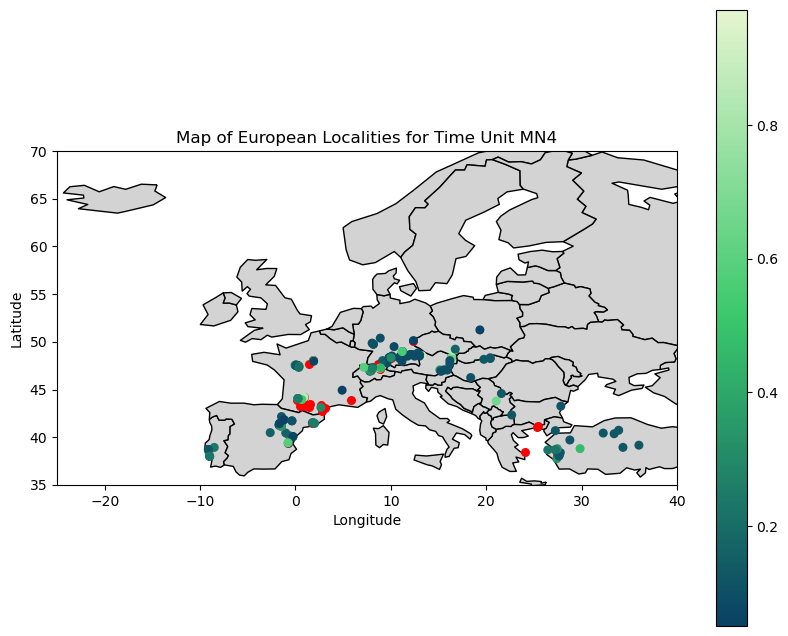

C:\Users\dream\AppData\Local\Temp\ipykernel_18020\1669705606.py:19: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


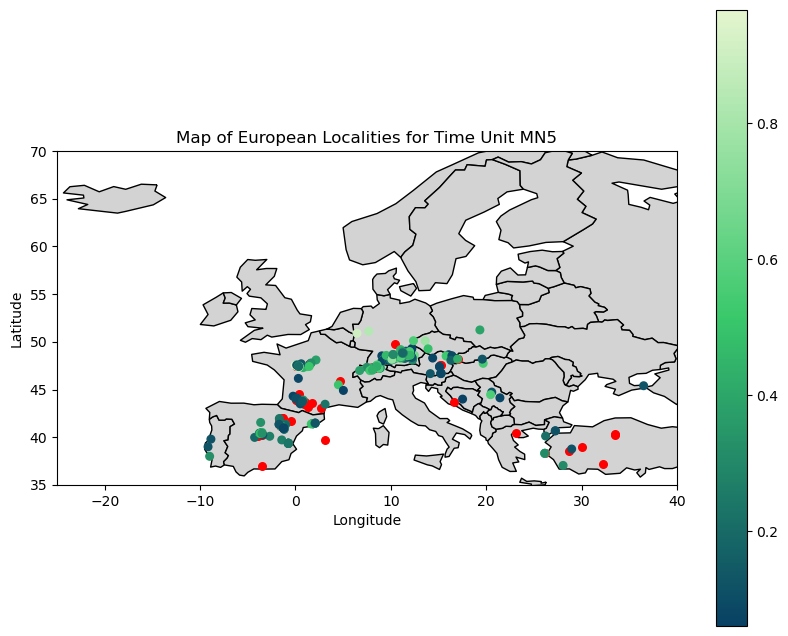

C:\Users\dream\AppData\Local\Temp\ipykernel_18020\1669705606.py:19: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


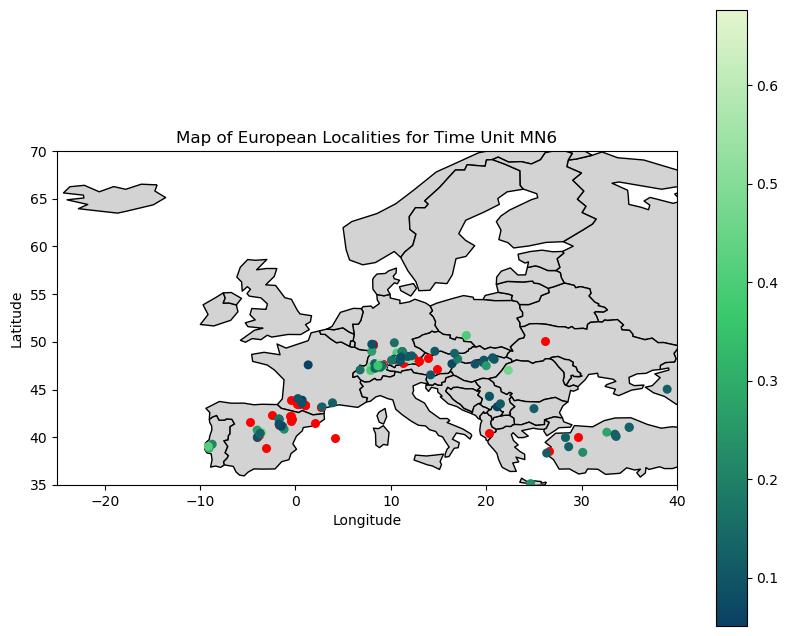

C:\Users\dream\AppData\Local\Temp\ipykernel_18020\1669705606.py:19: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


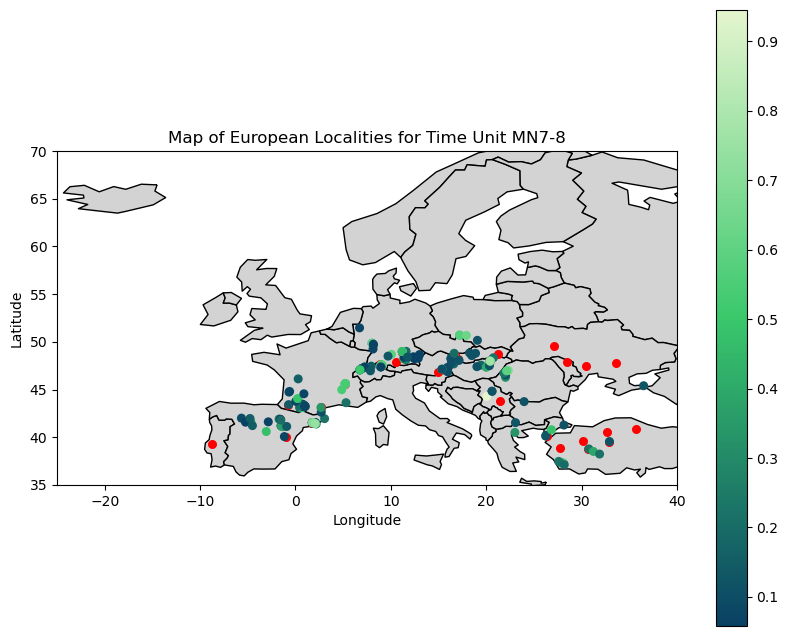

C:\Users\dream\AppData\Local\Temp\ipykernel_18020\1669705606.py:19: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


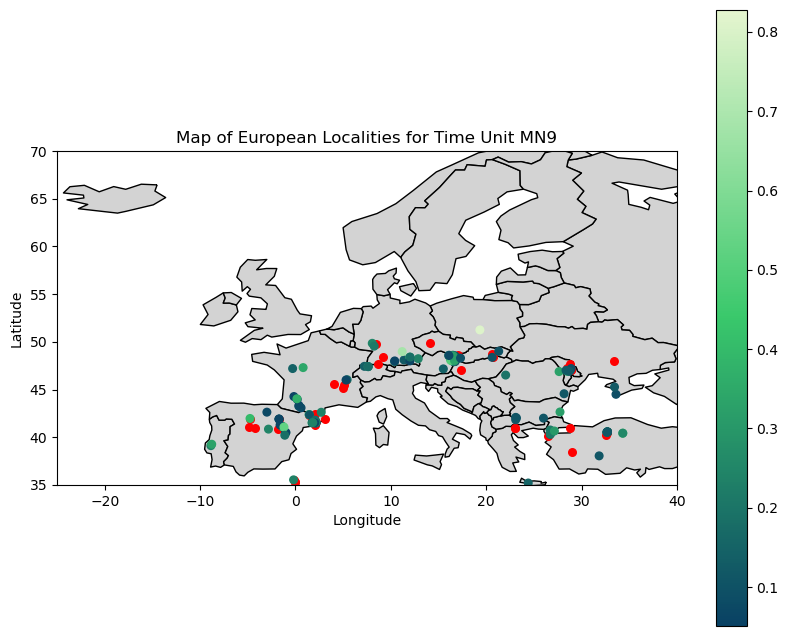

C:\Users\dream\AppData\Local\Temp\ipykernel_18020\1669705606.py:19: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


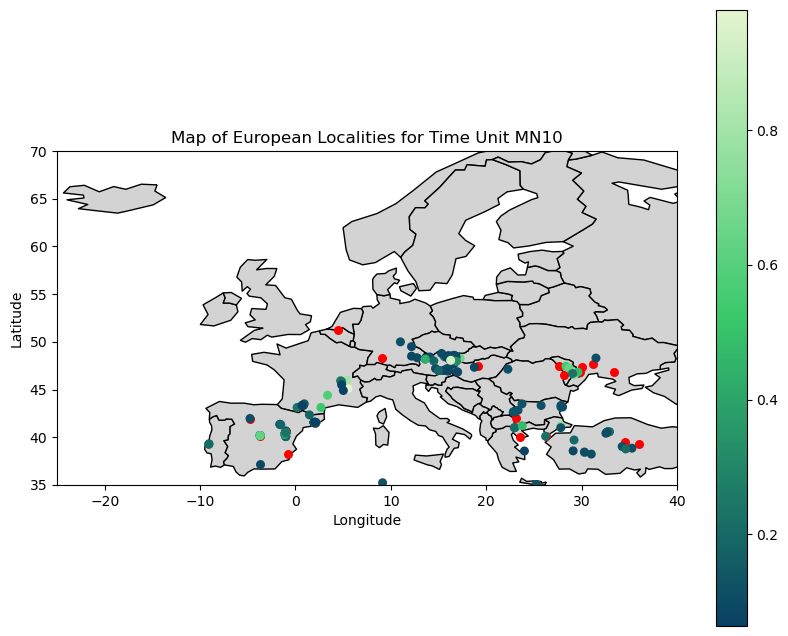

C:\Users\dream\AppData\Local\Temp\ipykernel_18020\1669705606.py:19: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


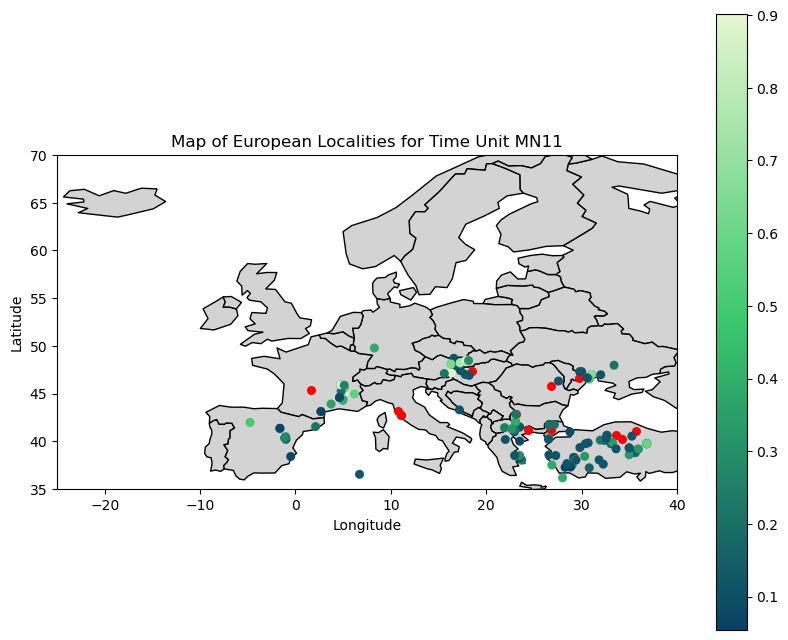

C:\Users\dream\AppData\Local\Temp\ipykernel_18020\1669705606.py:19: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


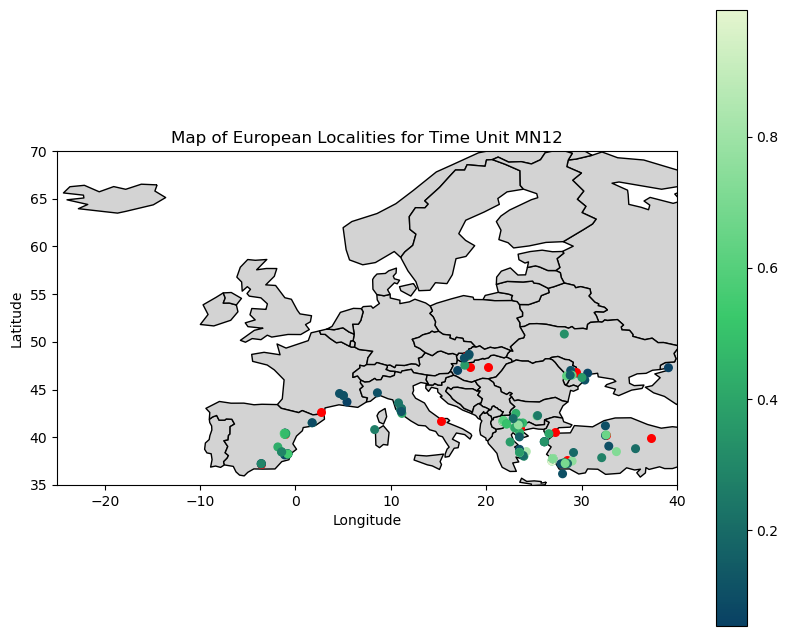

C:\Users\dream\AppData\Local\Temp\ipykernel_18020\1669705606.py:19: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


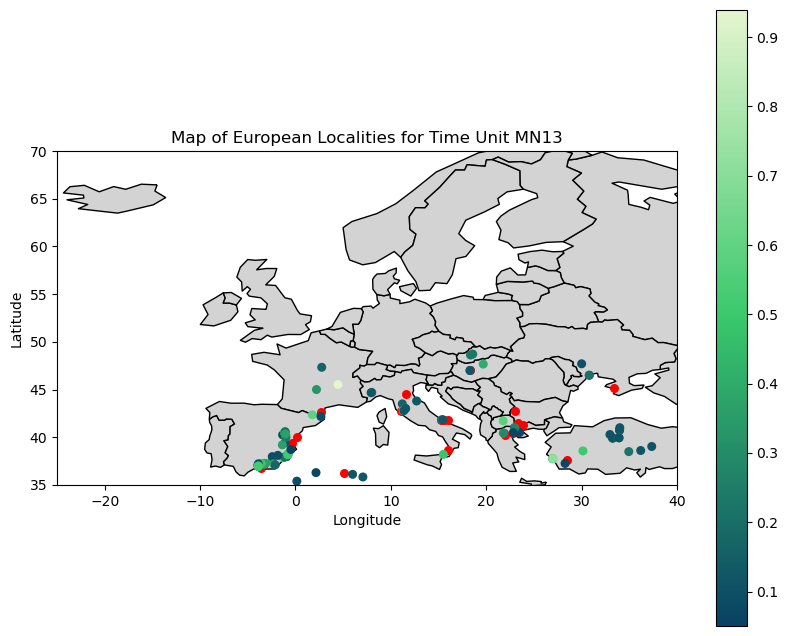

C:\Users\dream\AppData\Local\Temp\ipykernel_18020\1669705606.py:19: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


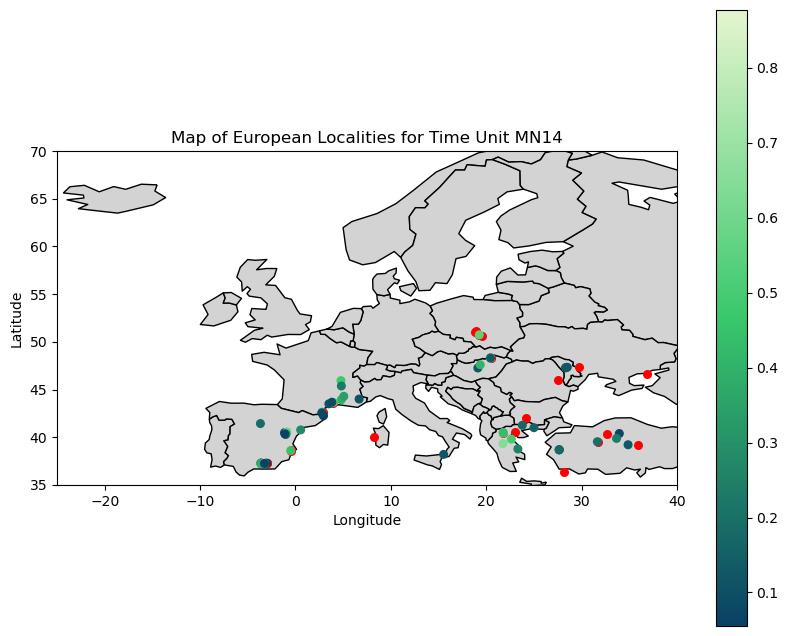

C:\Users\dream\AppData\Local\Temp\ipykernel_18020\1669705606.py:19: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


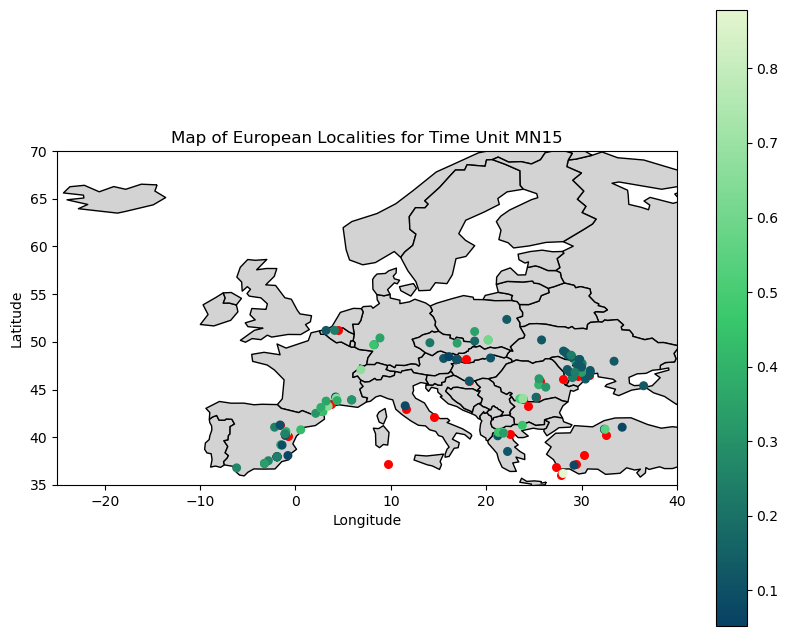

C:\Users\dream\AppData\Local\Temp\ipykernel_18020\1669705606.py:19: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


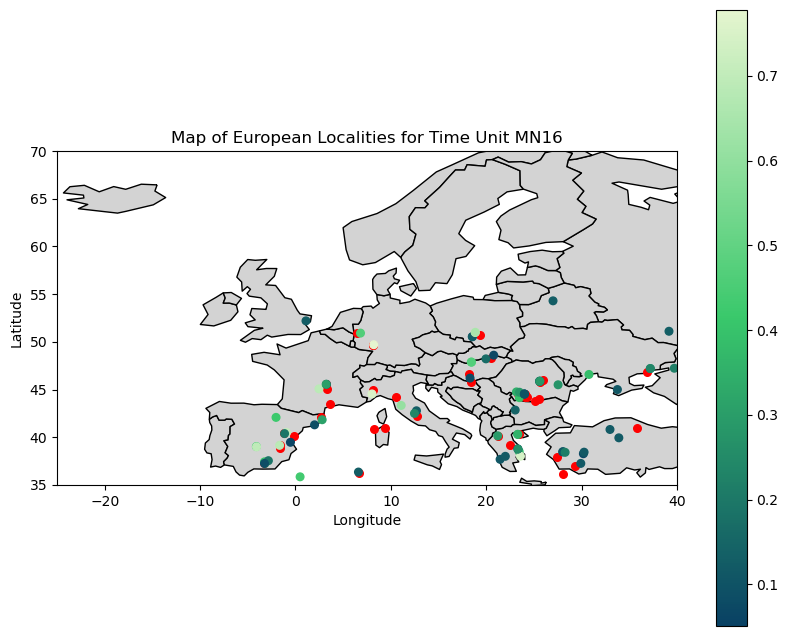

C:\Users\dream\AppData\Local\Temp\ipykernel_18020\1669705606.py:19: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


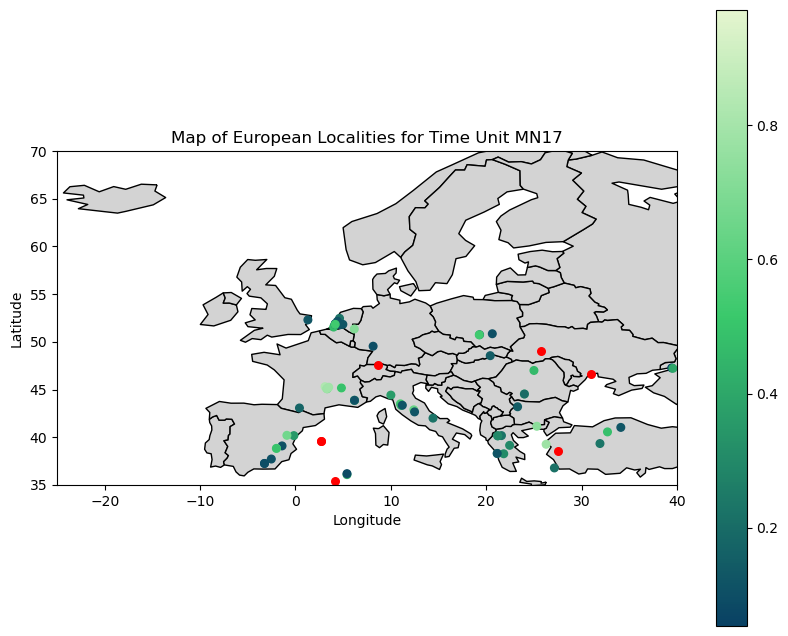

C:\Users\dream\AppData\Local\Temp\ipykernel_18020\1669705606.py:19: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


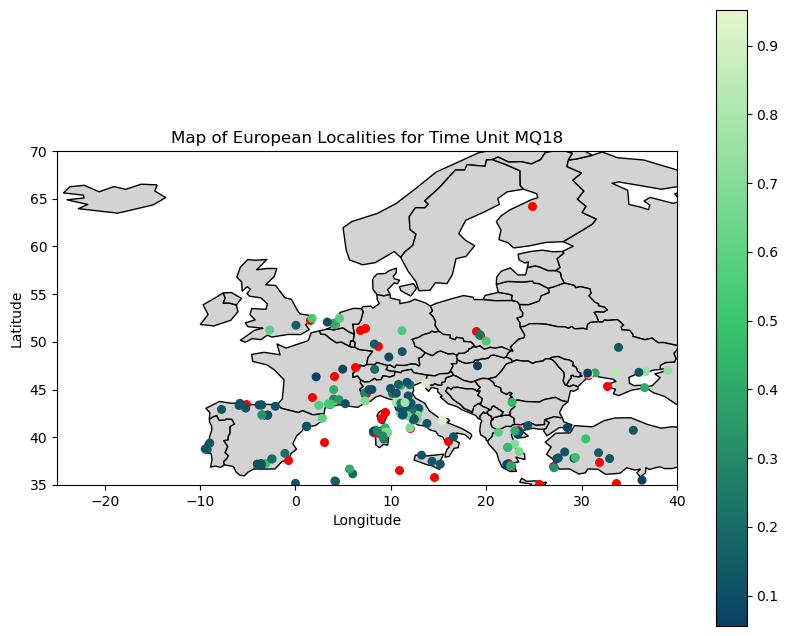

C:\Users\dream\AppData\Local\Temp\ipykernel_18020\1669705606.py:19: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


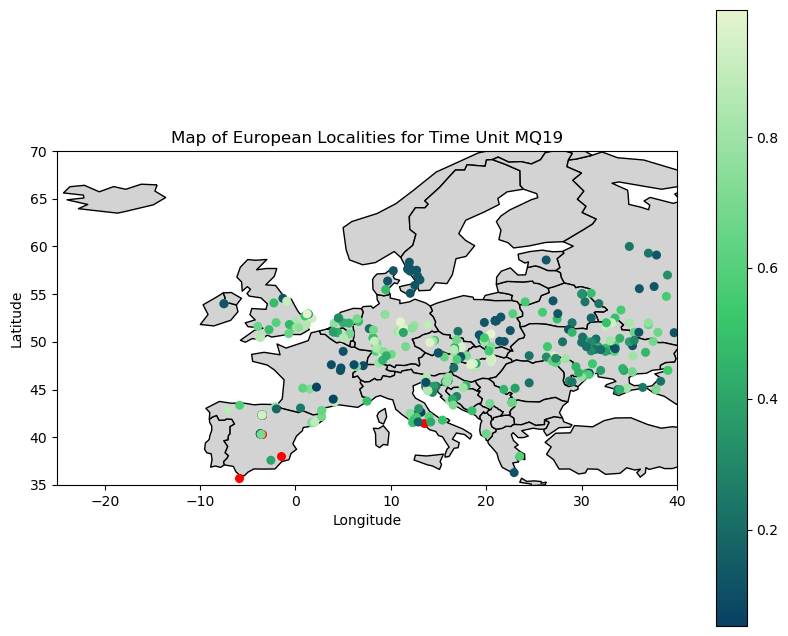

C:\Users\dream\AppData\Local\Temp\ipykernel_18020\1669705606.py:19: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


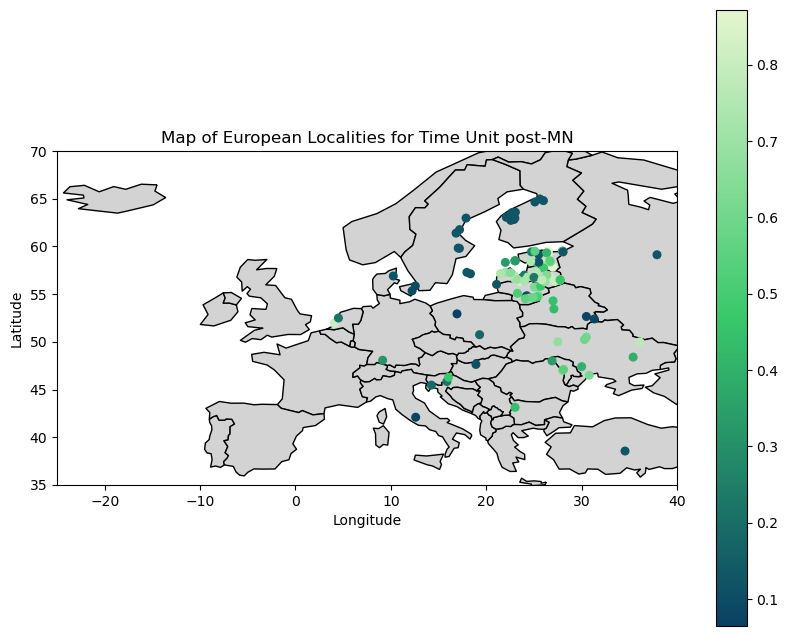

In [237]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# group by time periods
grouped_by_mn = filtered_localities.groupby('MN_order')

# color map
colors = [(9/255, 65/255, 100/255), (57/255, 200/255, 107/255), (229/255, 245/255, 207/255)]  # an interesting color scheme
cmap_name = 'custom_cmap'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

mn_names = {0: "pre-MN", 1: "MN1", 2: "MN2", 3: "MN3", 4: "MN4", 5: "MN5", 6: "MN6", 7: "MN7-8", 8: "MN9", 9: "MN10",
    10: "MN11", 11: "MN12", 12: "MN13", 13: "MN14", 14: "MN15", 15: "MN16", 16: "MN17", 17: "MQ18", 18: "MQ19", 19: "post-MN"} # to ensure proper order

for mn, group in grouped_by_mn: # for each MN, we plot a separate map

    gdf = gpd.GeoDataFrame(group, geometry=gpd.points_from_xy(group.LONG, group.LAT))
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    europe = world[(world['continent'] == 'Europe') | (world['name'] == 'Turkey')] # plot the map of Europe incl. Turkey
    ax = europe.plot(color='lightgrey', edgecolor='black', figsize=(10, 8))

    gdf[gdf['Probability'] < 0.05].plot(ax=ax, color='red', markersize=30) # highlight with red when p < 0.05
    gdf[gdf['Probability'] >= 0.05].plot(ax=ax, column='Probability', cmap=custom_cmap, legend=True, markersize=30)
    
    ax.set_title(f'Map of European Localities for Time Unit {mn_names[mn]}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xlim(-25, 40)
    ax.set_ylim(35, 70)
    plt.show()


For the first few time periods, the localities mostly are centered around northern Spain, central and southern France and Germany, as well as Switzerland. The probability of observations is usually high, with some cases of less than 0.05, highlighted in red. There are incidences in Anatolia, Czechia, Portugal, and Ukraine. 

From MN4, this expands to include most of Central Europe. The probability of observations in Southern France / Northern Spain are particular for being less than 0.05. There are nonetheless high incidences around the Pyrenees and Alps. 

From MN7-8, these probabilities around the Alps and Pyrenees are quite high, but this is not the case in Turkey and Ukraine, with lower probabilities. Furthermore, there are more incidences in Hungary and eastern Austria. 

From MN11, there are far more incidences around Greece and Turkey, with high probabilities, and virtually none around the Alps. Sampling in MN12-13 is higher in Moldova, Hungary, Greece and eastern Spain,  usually higher probabilities than 0.4.

In MN15, there is more sampling around Moldova with high probabilities. In MN16, there are usually low probabilities in most places, less than 0.05. 

In MQ17, there are far more incidences of high probability of observances in northern and central Italy, as well as Sardinia. More sampling in the north of Europe as well, with some cases of less than 0.05 probability. 

MQ19 is unique with lots of sampling separated across Europe, with medium to high probabilities of observances. Much of Germany, Benelux, Britain, Ukraine, Poland, Belarus, and Russia is covered in this. 

Post-MN much of the sampling seems to be in the Baltic Countries, and the probabilities of being first observances are medium to high, especially as many observances of previous time periods did not occur in this location.